# **Modelo de Detección de Fraude**

## Modelo de Detección de Fraude con XGBoost y LightGBM

Este notebook implementa un sistema integral de detección de fraude utilizando aprendizaje automático. Exploraremos el conjunto de datos, realizaremos ingeniería de características, abordaremos el desbalance de clases y evaluaremos múltiples modelos, incluyendo XGBoost y LightGBM.

### **¿Qué son XGBoost y LightGBM?**

Ambos son algoritmos de boosting basados en árboles de decisión. El boosting es una técnica de ensemble (ensamblado) que construye modelos secuencialmente, donde cada nuevo modelo trata de corregir los errores del anterior. El resultado es un modelo final muy preciso.

### **¿Qué tienen en común?**

* Se basan en árboles de decisión.

* Aplican Gradient Boosting: los árboles nuevos se entrenan sobre los errores (residuos) de los árboles anteriores.

* Soportan tareas de clasificación y regresión.

* Incluyen mecanismos de regularización para evitar sobreajuste.

* Son altamente paralelizables y eficientes.


### **Diferencias clave entre XGBoost and LightGBM**

| Característica        | **XGBoost**                                           | **LightGBM**                                               |
|-----------------------|------------------------------------------------------|-------------------------------------------------------------|
| Estrategia de crecimiento | *Nivel por nivel* (level-wise)                         | *Hoja por hoja* (leaf-wise), más profundo y preciso         |
| Velocidad              | Rápido, pero menos que LightGBM                      | Más rápido en datasets grandes                              |
| Uso de memoria         | Alto (requiere optimización)                         | Más eficiente                                               |
| Soporte de variables categóricas | No nativo (hay que codificar)                     | ✅ Nativo (detecta y maneja categorías automáticamente)      |
| Precisión              | Muy alta                                             | Muy alta (y a veces superior a XGBoost)                     |
| Tolerancia a desbalance de clases | Requiere ajuste manual del parámetro `scale_pos_weight` | También requiere, pero es más sensible a valores extremos   |

### **¿Cómo funcionan internamente?**

#### **XGBoost (Extreme Gradient Boosting):**

* Construye árboles de decisión en secuencia.

* Cada nuevo árbol intenta minimizar una función de pérdida (como log loss o MSE) usando el gradiente.

* Aplica poda (pre-poda/post-poda) para evitar árboles muy grandes.

* Usa técnicas de regularización (alpha, lambda) para evitar sobreajuste.

* Es muy usado en Kaggle y competencias de ciencia de datos por su robustez y precisión.

#### **LightGBM (Light Gradient Boosting Machine):

* Utiliza hoja por hoja para crecer árboles, lo que da mejores divisiones.

* Implementa histogramas de binning, agrupando valores para acelerar la construcción del árbol.

* Se escala muy bien a millones de registros y miles de características.

* Tiene un parámetro llamado max_bin que ayuda a reducir memoria y aumentar velocidad.

* También admite entrenamiento distribuido en múltiples máquinas.

#### ¿cuándo usar cada uno?

| Escenario | Recomendación |
|----------|----------------|
| Dataset grande (>100K filas) | **LightGBM** es más rápido y eficiente. |
| Necesitas interpretar el modelo | Ambos permiten obtener **importancia de variables**, pero **XGBoost** es más fácil de controlar. |
| Desbalance de clases | Ambos funcionan bien, pero debes ajustar parámetros (`scale_pos_weight`, `class_weight`). |
| Entrenamiento distribuido o escalado | **LightGBM** está mejor optimizado para esto. |

## **Descripción del Conjunto de Datos**

El conjunto de datos contiene información sintética de transacciones financieras diseñada para la detección de fraude, con:

* 50.000 transacciones

* 21 variables (incluyendo la variable objetivo)

* Clasificación binaria (fraude vs. no fraude)

## **Diccionario de Variables**

| Variable                        | Descripción                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| **Transaction_ID**             | Identificador único de la transacción.                                      |
| **User_ID**                    | Identificador del usuario que realizó la transacción.                      |
| **Transaction_Amount**         | Monto en dólares de la transacción.                                        |
| **Transaction_Type**           | Tipo de transacción (ej: POS, Online, Transferencia bancaria).             |
| **Timestamp**                  | Fecha y hora exacta de la transacción.                                     |
| **Account_Balance**            | Saldo de la cuenta del usuario al momento de la transacción.               |
| **Device_Type**                | Tipo de dispositivo usado (Laptop, Tablet, Mobile).                        |
| **Location**                   | Ciudad o región donde ocurrió la transacción.                              |
| **Merchant_Category**          | Categoría del comercio (Ropa, Electrónica, Viajes, etc.).                  |
| **IP_Address_Flag**            | Indicador si la IP es sospechosa (0 = No, 1 = Sí).                         |
| **Previous_Fraudulent_Activity** | Número de fraudes previos asociados al usuario.                            |
| **Daily_Transaction_Count**    | Número de transacciones realizadas ese día por el usuario.                 |
| **Avg_Transaction_Amount_7d**  | Promedio del monto de transacciones en los últimos 7 días.                |
| **Failed_Transaction_Count_7d**| Número de transacciones fallidas en los últimos 7 días.                   |
| **Card_Type**                  | Tipo de tarjeta utilizada (Visa, Mastercard, Amex, etc.).                  |
| **Card_Age**                   | Antigüedad de la tarjeta (en días).                                        |
| **Transaction_Distance**       | Distancia (en km) entre ubicación habitual del usuario y del comercio.     |
| **Authentication_Method**      | Método de autenticación usado (Biometría, Contraseña, OTP).               |
| **Risk_Score**                 | Puntaje de riesgo asignado por algún sistema interno (entre 0 y 1).        |
| **Is_Weekend**                 | Si ocurrió en fin de semana (0 = No, 1 = Sí).                              |
| **Fraud_Label**                | Variable objetivo: 1 = Fraude, 0 = No fraude.                              |

In [2]:
!pip install --upgrade --force-reinstall numpy==1.23.5 scikit-learn==1.1.3 imbalanced-learn==0.10.1

  Using cached imbalanced_learn-0.10.1-py3-none-any.whl.metadata (8.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 21.0 MB/s eta 0:00:00
Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_auc_score, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# Set aesthetic parameters
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

# **Carga de Datos y Exploración Inicial**


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Simulación 2025-1/Clasificación/Datos_Detección_Fraude.csv")

# Display basic info
print(f"Dimensión del conjunto de datos: {df.shape}")
print("\nVisualización de las 5 primeras filas:")
display(df.head())

Dimensión del conjunto de datos: (50000, 21)

Visualización de las 5 primeras filas:


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1



Tipos de variables y datos nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d

In [27]:
print("\nTipos de variables y datos nulos:")
print(df.info())
print("\nDistribución de la variable de respuesta:")
print(df['Fraud_Label'].value_counts(normalize=True))


Tipos de variables y datos nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Transaction_Amount             50000 non-null  float64
 1   Transaction_Type               50000 non-null  int64  
 2   Account_Balance                50000 non-null  float64
 3   Device_Type                    50000 non-null  int64  
 4   Location                       50000 non-null  int64  
 5   Merchant_Category              50000 non-null  int64  
 6   IP_Address_Flag                50000 non-null  int64  
 7   Card_Type                      50000 non-null  int64  
 8   Card_Age                       50000 non-null  int64  
 9   Transaction_Distance           50000 non-null  float64
 10  Authentication_Method          50000 non-null  int64  
 11  Risk_Score                     50000 non-null  float64
 12  Is_Weekend 

# Ingeniería de Características


In [6]:
# Drop unnecessary IDs
df.drop(['Transaction_ID', 'User_ID'], axis=1, inplace=True)

In [7]:
# Convertir la marca de tiempo a formato datetime y extraer características
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
df.drop('Timestamp', axis=1, inplace=True)

In [8]:
# Create new features
df['Transaction_Amount_to_Balance'] = df['Transaction_Amount'] / (df['Account_Balance'] + 1)
df['Transaction_Frequency_Ratio'] = df['Daily_Transaction_Count'] / (df['Avg_Transaction_Amount_7d'] + 1)
df['Failed_Transaction_Rate'] = df['Failed_Transaction_Count_7d'] / (df['Daily_Transaction_Count'] + 1)
df['Risk_History_Ratio'] = df['Previous_Fraudulent_Activity'] / (df['Card_Age'] + 1)

In [9]:
# Drop redundant features
df.drop(['Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
         'Failed_Transaction_Count_7d', 'Previous_Fraudulent_Activity'], axis=1, inplace=True)

# **Análisis Exploratorio de Datos**


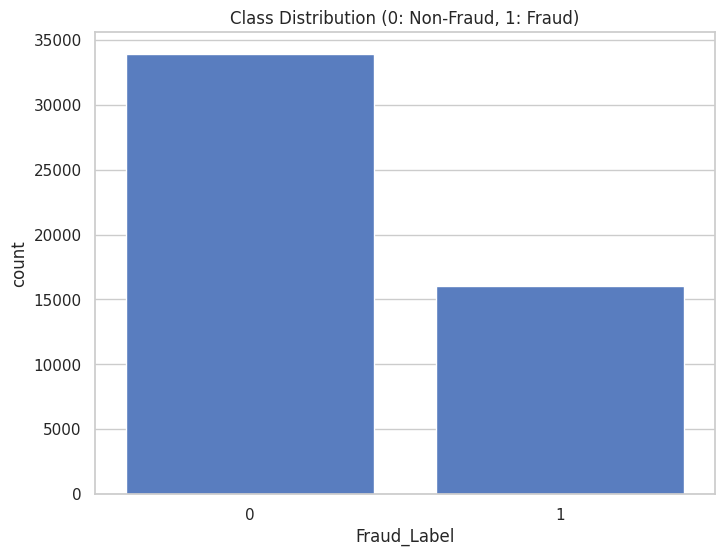

In [10]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Fraud_Label', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

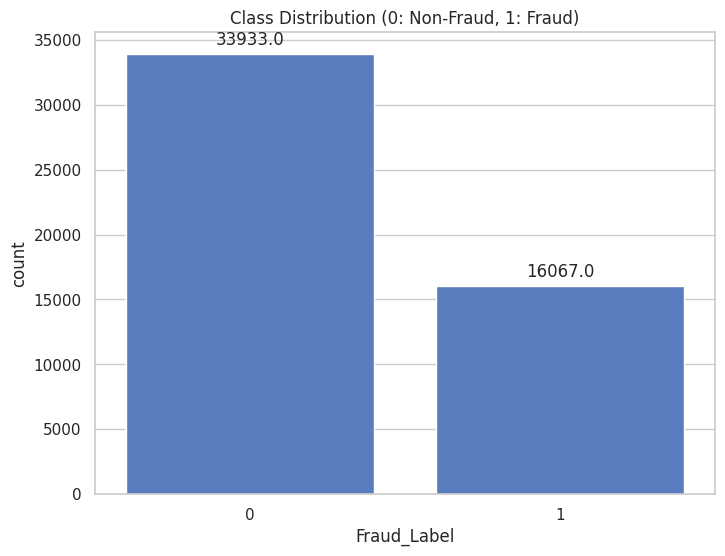

In [11]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Fraud_Label', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


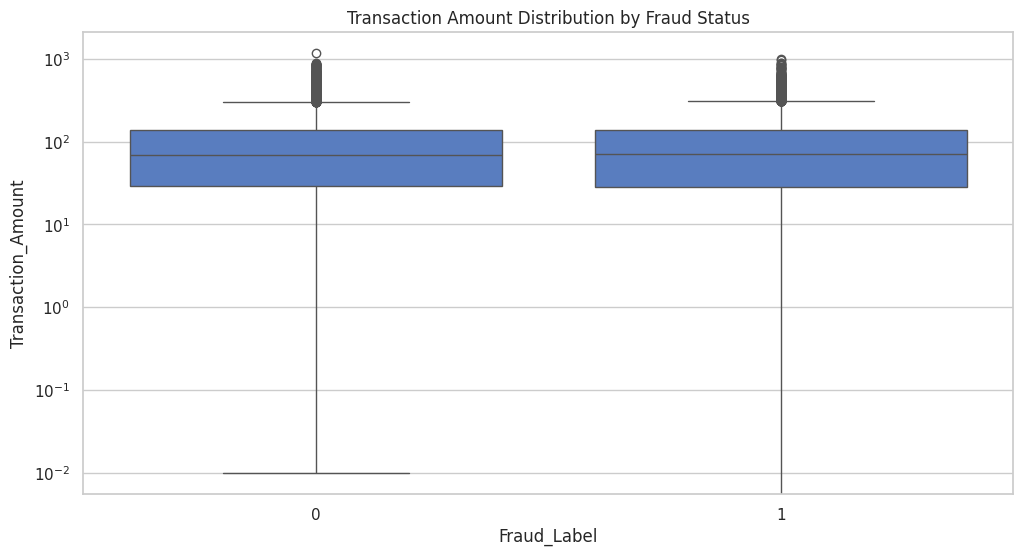

In [12]:
# Plot transaction amount by fraud status
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fraud_Label', y='Transaction_Amount', data=df)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.yscale('log')  # Log scale for better visualization
plt.show()

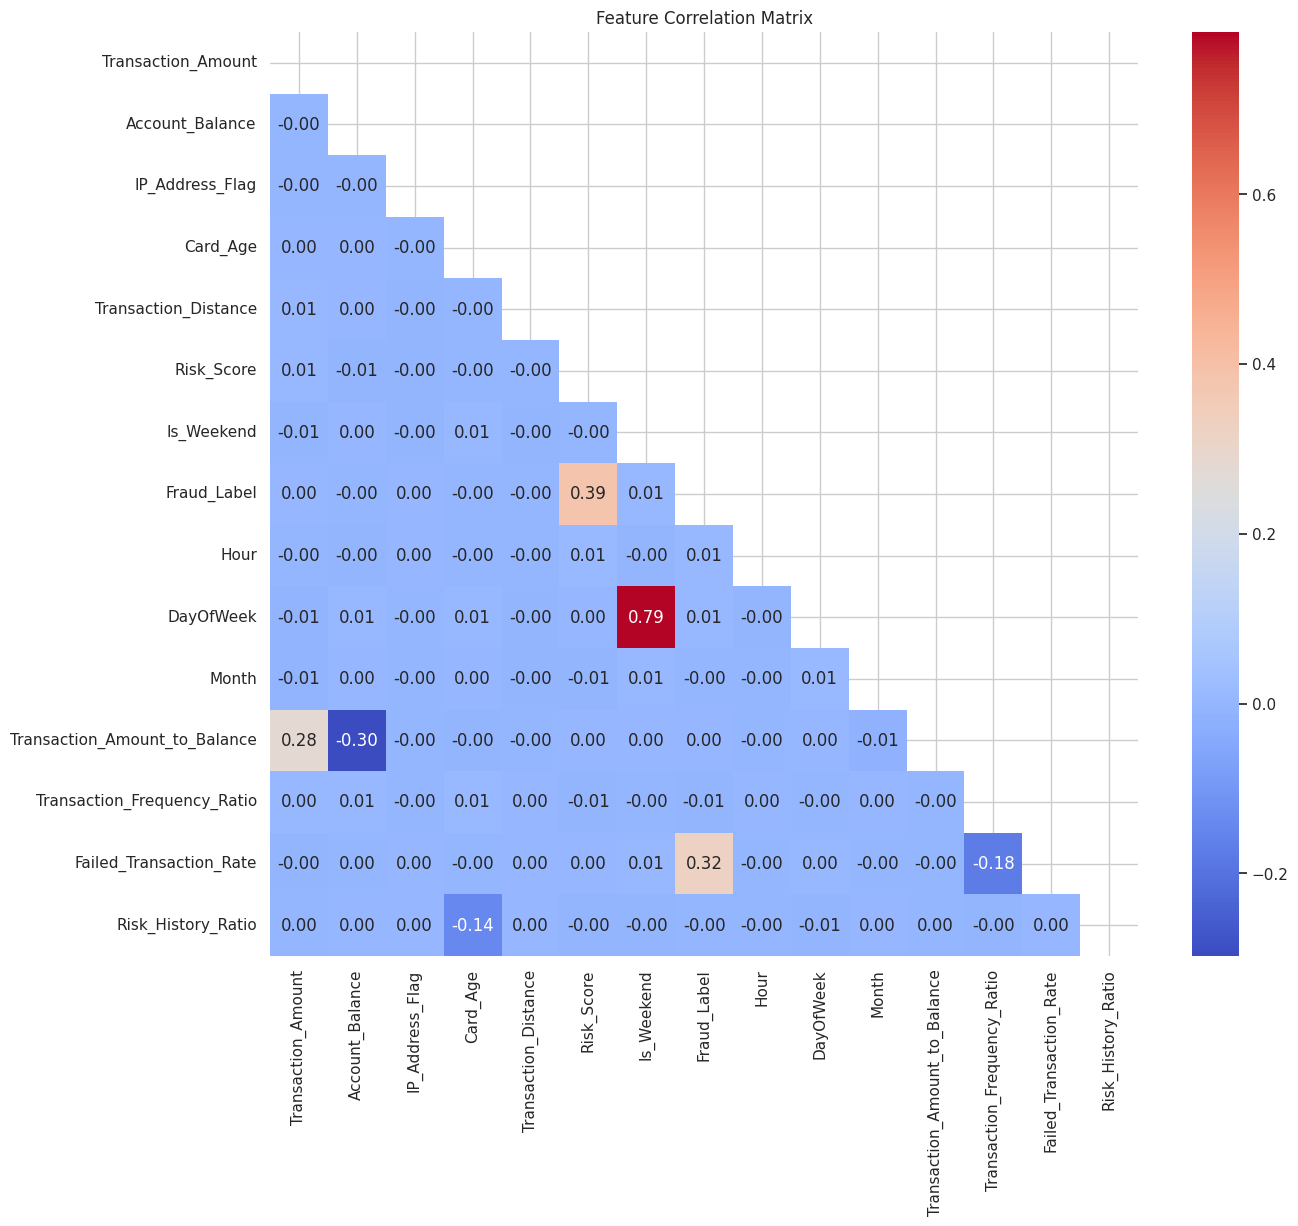

In [13]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Feature Correlation Matrix')
plt.show()

# Preprocesamiento de Datos


In [ ]:
# Manejar variables categóricas
cat_cols = ['Transaction_Type', 'Device_Type', 'Location',
            'Merchant_Category', 'Card_Type', 'Authentication_Method']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Split features and target
X = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

In [14]:
# Manejar variables categóricas
cat_cols = ['Transaction_Type', 'Device_Type', 'Location',
            'Merchant_Category', 'Card_Type', 'Authentication_Method']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [15]:
df.head()

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Card_Type,Card_Age,Transaction_Distance,...,Risk_Score,Is_Weekend,Fraud_Label,Hour,DayOfWeek,Month,Transaction_Amount_to_Balance,Transaction_Frequency_Ratio,Failed_Transaction_Rate,Risk_History_Ratio
0,39.79,3,93213.17,0,3,4,0,0,65,883.17,...,0.8494,0,0,19,0,8,0.000427,0.015959,0.375000,0.000000
1,1.19,1,75725.25,1,2,0,0,2,186,2203.36,...,0.0959,0,1,4,2,6,0.000016,0.027097,0.285714,0.000000
2,28.96,2,1588.96,2,1,3,0,3,226,1909.29,...,0.8400,0,1,15,1,6,0.018214,0.274456,0.266667,0.000000
3,254.32,0,76807.20,2,2,0,0,3,76,1311.86,...,0.7935,0,1,0,3,12,0.003311,0.043601,0.444444,0.000000
4,31.28,3,92354.66,1,1,1,0,2,140,966.98,...,0.3819,1,1,23,5,11,0.000339,0.042464,0.266667,0.007092


In [16]:
# Split features and target
X = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

# Model Training and Evaluation

XGBoost Classifier

In [19]:
# Initialize and train XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [22]:
xgb.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [23]:
# Predictions
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

In [24]:
# Evaluation
print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
Accuracy: 0.9505
ROC AUC: 0.9937

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      6787
           1       0.91      0.94      0.92      3213

    accuracy                           0.95     10000
   macro avg       0.94      0.95      0.94     10000
weighted avg       0.95      0.95      0.95     10000



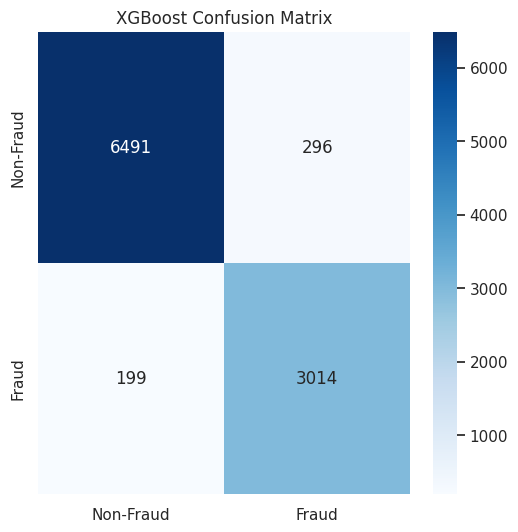

In [25]:
# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('XGBoost Confusion Matrix')
plt.show()

<Figure size 1200x800 with 0 Axes>

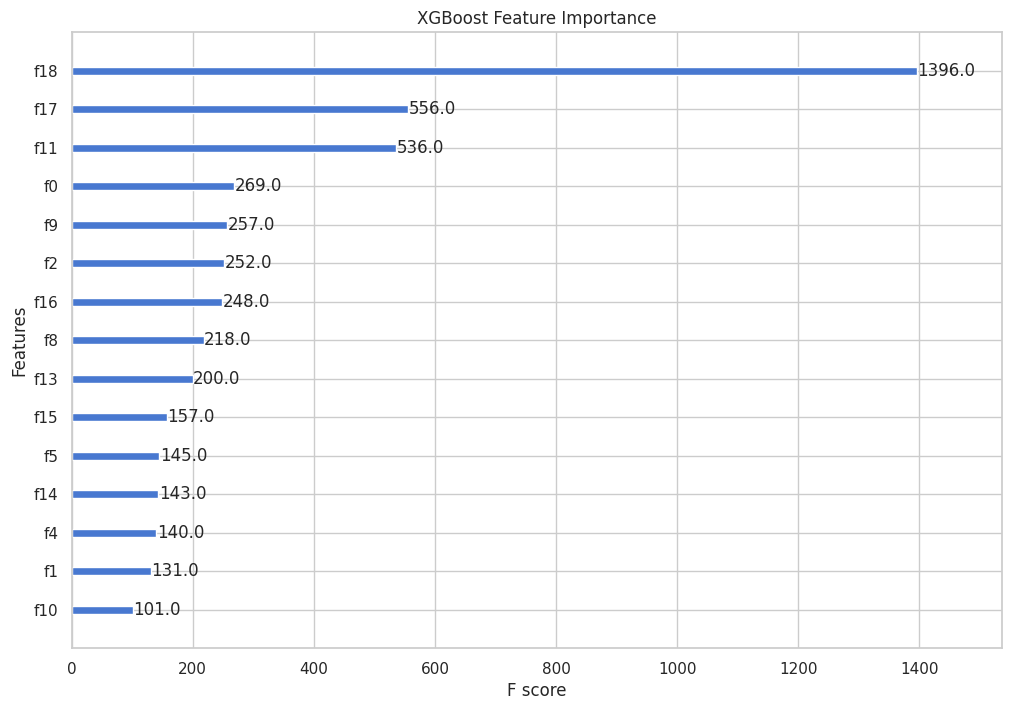

In [26]:
# Feature importance
plt.figure(figsize=(12, 8))
plot_importance(xgb, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.show()

# LightGBM Classifier


In [28]:
# Initialize and train LightGBM
lgbm = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [29]:
lgbm.fit(X_res, y_res)

[LightGBM] [Info] Number of positive: 27146, number of negative: 27146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4624
[LightGBM] [Info] Number of data points in the train set: 54292, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=5,
               metric='binary_logloss', n_estimators=300, objective='binary',
               random_state=42, subsample=0.8)

In [30]:
# Predictions
y_pred_lgbm = lgbm.predict(X_test_scaled)
y_prob_lgbm = lgbm.predict_proba(X_test_scaled)[:, 1]

In [31]:
# Evaluation
print("LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgbm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

LightGBM Performance:
Accuracy: 0.9502
ROC AUC: 0.9937

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      6787
           1       0.91      0.94      0.92      3213

    accuracy                           0.95     10000
   macro avg       0.94      0.95      0.94     10000
weighted avg       0.95      0.95      0.95     10000



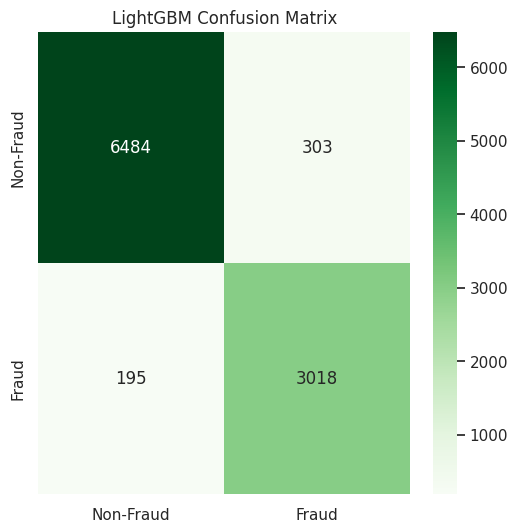

In [32]:
# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('LightGBM Confusion Matrix')
plt.show()

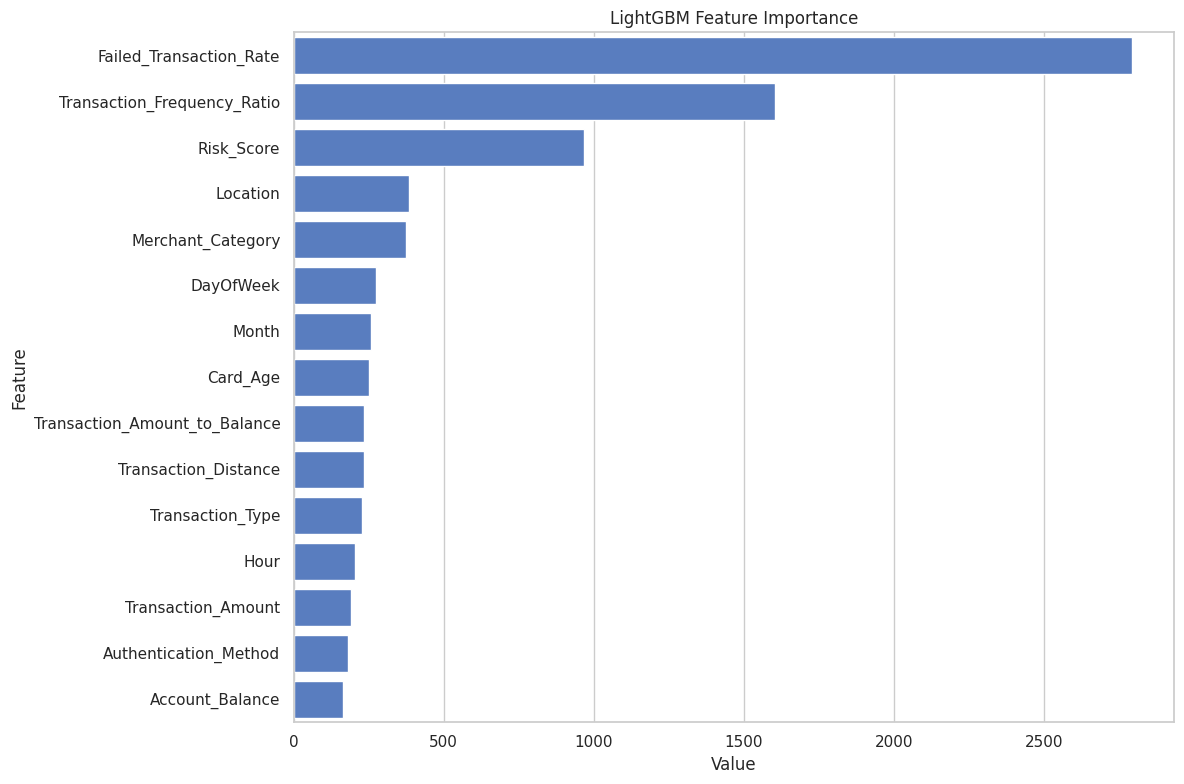

In [33]:
# CORRECT WAY TO PLOT LIGHTGBM FEATURE IMPORTANCE
plt.figure(figsize=(12, 8))
feature_imp = pd.DataFrame({
    'Value': lgbm.feature_importances_,
    'Feature': X.columns
})
feature_imp = feature_imp.sort_values(by="Value", ascending=False).head(15)
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# Model Comparison and Selection


In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Compare model performance
models = {
    'XGBoost': y_prob_xgb,
    'LightGBM': y_prob_lgbm
}

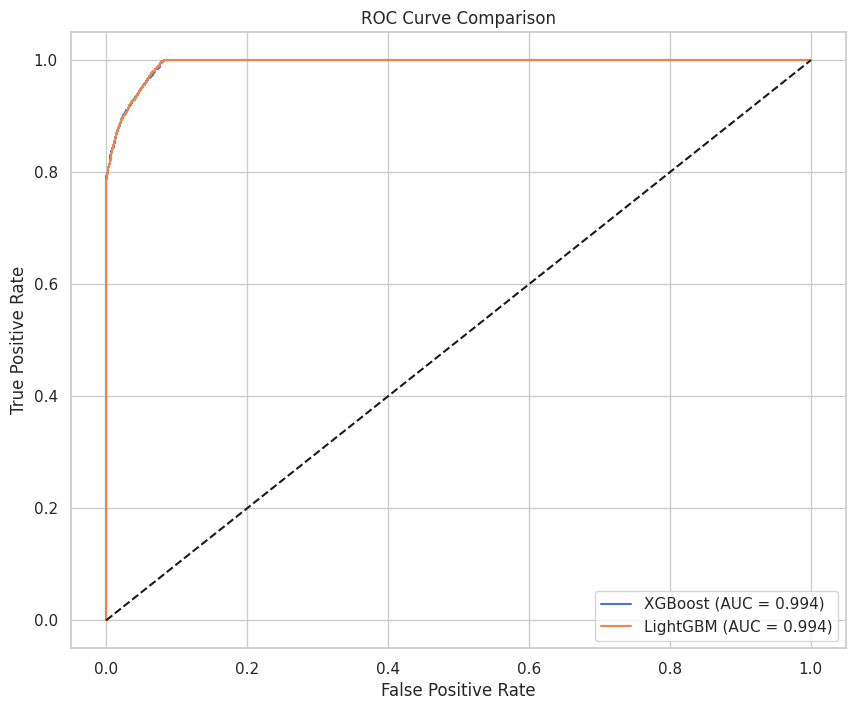

In [35]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, y_prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

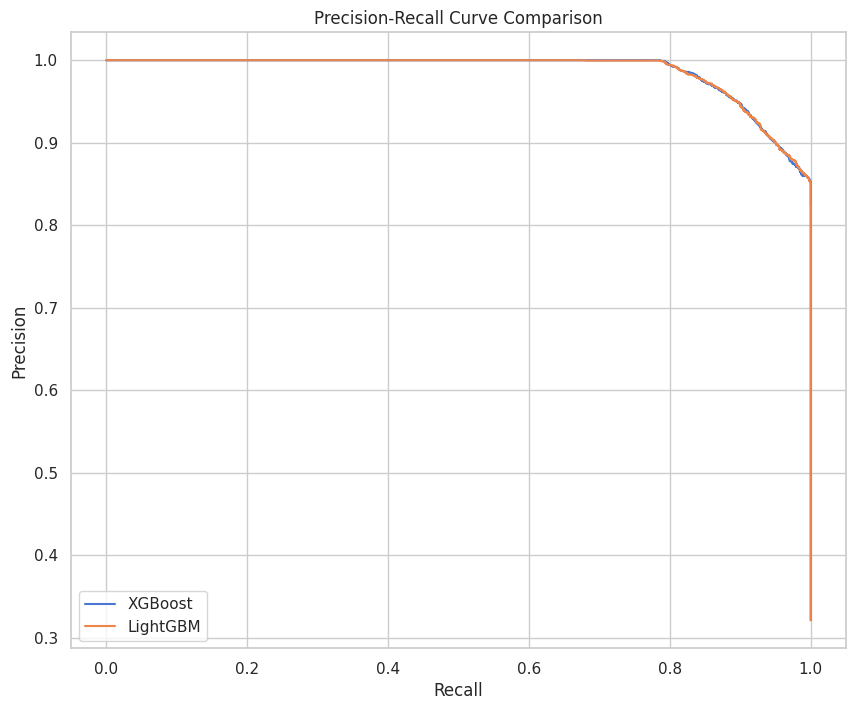

In [36]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, y_prob in models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a7b0fb46-4a02-4684-9408-b59a17ec8b00' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>